# Background
Scientists define there to be two main types of age: chronological, and biological age. Chronological age is based on how long you have been alive (years since birth), whereas biological age is a rough estimate of how healthy your body is by measuring various different biomarkers. For more information on this, check out my recent article on biological age right here: [What is Biological Age?](https://medium.com/biotein/what-is-biological-age-383692f53e60)

One way of determining biological age (as also described in the article) is to measure the methylation levels in your genome. At sites known as CpG sites, along your DNA, various proteins can add on or remove methyl groups, in order to control which genes are expressed into proteins, and which ones aren't. As you age, however, the systems responsible for maintaining this control of the genome begin to break down, leading to errors in methylation. As such, some sites begin to see an accumulation of methyl tags, while others have their tags removed, as you age.

Dr. Steve Horvath, longevity researcher at University of California Los Angeles, used this progression to develop a system known as the Horvath aging clock, which is able to produce an accurate estimate of your biological age. For example, after analyzing the methylation levels in a sample of your cells, the clock might tell you that your biological age is around 30, which basically means that your methylation levels (and your body's health) is similar to the average 30-year-old. If your actual age is somewhere around 40, this means you are living a healthy life, whereas if you are only 20 years old, then this suggests that you are living an unhealthy life. This information thus equips people with the knowledge to take control of their lifestyle and live a healthy life.

# Brief Explanation of This Project
In this project, I aim to somewhat replicate the epigenetic clock developed by Horvath, using methylation data taken from blood samples to predict an individual's age. The datasets and methylation sites chosen for this project were advised by the research paper titled [Human Age Prediction Based on DNA Methylation Using a Gradient Boosting Regressor](https://doi.org/10.3390/genes9090424).
There are two notable differences between the paper and this code:
1. Since this code also takes into account the gender of the patients whose methylation data is available, GSE30870, which does not contain gender information in the dataset, was removed from the sample.
2. This notebook contains three different ML Regression algorithms and a Deep Neural Network, and compares the performance of each model on the training and testing dataset. The four models developed in this notebook are: Multivariable Linear Regression, Random Forest Regression, Gradient Boosting Regression, and a Deep Neural Network.

In [1]:
# Imports
import pandas as pd

from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import numpy as np

In [2]:
# Loading methylation dataset using Pandas
path = "Enter your path here"
df = pd.read_csv(path)
df.head()

,...1,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,gender,age
0,GSM507152,0.392464,0.281630,0.352591,0.315924,0.111604,0.211683,1.0,71.06
1,GSM507153,0.377919,0.238900,0.520396,0.323641,0.127965,0.184307,1.0,69.65
2,GSM507154,0.458522,0.204078,0.519273,0.363714,0.119891,0.215067,1.0,65.79
3,GSM507155,0.479108,0.154893,0.618859,0.493972,0.088941,0.240057,1.0,49.39
4,GSM507156,0.418763,0.217832,0.561005,0.398580,0.085992,0.207462,1.0,60.68


Here we first shuffle our dataset to remove any confounding factors that may exist as a result of the ordering of the dataset, such as an inappropriate train-test split.

In [3]:
# Shuffle dataframe to randomize data order, possibly preventing confounding factors
df = shuffle(df)
df.reset_index(inplace=True, drop=True)

# Remove patient ID column
df = df.drop(['...1'], axis=1)

# Drop all rows with NaN values
df = df.dropna()

df.head()

,cg09809672,cg22736354,cg02228185,cg01820374,cg06493994,cg19761273,gender,age
0,0.709000,0.085300,0.796000,0.704000,0.063700,0.327000,1.0,0.000000
1,0.893000,0.024700,0.820000,0.854000,0.022800,0.426000,1.0,0.000000
2,0.606990,0.075370,0.693870,0.525770,0.040520,0.271890,0.0,5.666667
3,0.444817,0.327044,0.762018,0.261705,0.269671,0.259167,1.0,58.587270
4,0.502900,0.071740,0.705690,0.508110,0.052470,0.246320,0.0,9.000000


In [4]:
# Checking if there are any remaining NaNs in the dataset
np.where(pd.isnull(df))

(array([], dtype=int64), array([], dtype=int64))

Below, we plot the correlation matrix, or heatmap, to compare the variables. As can be seen in the lowest row (labelled age),  the methylation sites that might be the best predictors of age (the most strongly correlated, whether negative or positive) are cg09809672, cg01820374, and cg19761273.
We also see that gender seems to have a positive positive correlation with age. This suggests a possible confounding factor that may arise as a result of the dataset, since it seems that the females in the dataset (labelled as 1) are older than the males (labelled 0).

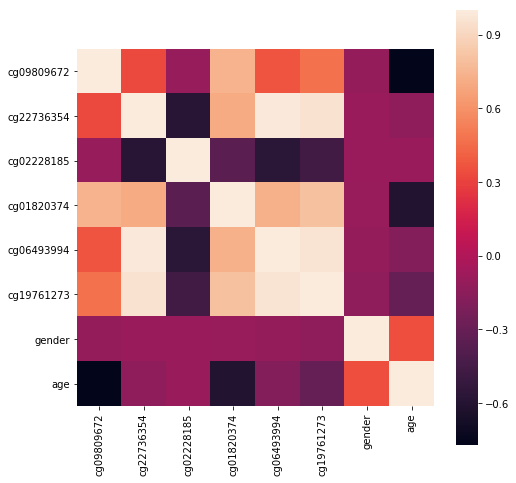

In [5]:
# Plot correlation matrix, or heatmap, to compare variables. As can 
# be seen in the lowest row (labelled age), the methylation sites
# that might act as the best predictors of age are cg09809672,
# cg01820374, and cg19761273.
import seaborn as sb
C_mat = df.corr()
fig = plt.figure(figsize = (8,8))

sb.heatmap(C_mat, vmax=1, square=True)
plt.show()

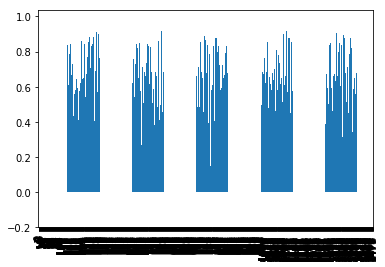

In [6]:
# Plotting the data for cg09809672 prior to normalization by the Standard Scaler model
df['cg09809672'].plot(kind='bar')

In [7]:
# Normalizing the methylation and gender data with a Standard Scaler.
X = df[['cg09809672', 'cg22736354', 'cg02228185', 'cg01820374', 'cg06493994', 'cg19761273', 'gender']]
std_scaler = StandardScaler()
std_scaler

# Separating X vs. y dataframes
X_std = pd.DataFrame(std_scaler.fit_transform(X), columns=X.columns)
y = df['age']

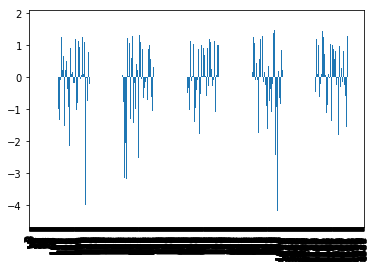

In [8]:
# Plotting the data for cg09809672 after normalization
X_std['cg09809672'].plot(kind='bar')

In [9]:
# Separating dataset into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

Based on the score and predictions printed below, we see that the linear regression model is only somewhate capable of accurately predicting the age of an individual using the methylation levels inputted, with roughly 71% testing accuracy (varies with each run).

In [10]:
# Training the multivariate linear regression model
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X_train, y_train)

# Accuracy on the testing set
print(linear_regressor.score(X_test, y_test))

0.7062188257332627


In [11]:
predictions = linear_regressor.predict(X_test)

# Since age cannot be negative, changing all negative predictions to age 0
for n, element in enumerate(predictions):
    if element < 0:
        predictions[n] = 0

# Looking at sample predictions for the testing set
for i in range(0, 10):
    print("Prediction:", predictions[i], "\tActual:", y_test.iloc[i])

Prediction: 3.361980696164494 	Actual: 0.0
Prediction: 36.606907811684025 	Actual: 39.0
Prediction: 42.917863357996325 	Actual: 32.0
Prediction: 0.0 	Actual: 0.0
Prediction: 4.785013030628292 	Actual: 0.0
Prediction: 0.0 	Actual: 0.0
Prediction: 45.36119480726499 	Actual: 68.2
Prediction: 41.984695386735865 	Actual: 49.39
Prediction: 11.024138615537836 	Actual: 0.0
Prediction: 0.0 	Actual: 0.0


Looking at the score for the model below, we can see that the Random Forest Regressor model is quite accurate at predicting an individual's age using their methylation data, with roughly 92% testing accuracy (varies with each run).
It is interesting to note, however, that in the predictions printed below, the model's predictions are not always close (such as predicting roughly 28.77 for someone who is actually 49.39 years. This may be either due to fact that the model is unable to accurately predict for 8% of the testing set, and the example shown may happen to be part of that 8%, or it could be because the specific individuals in question are outliers (much more or less healthier than the average person in their age demographic).

In [12]:
# Building and training the Random Forest Regressor model
from sklearn.ensemble import RandomForestRegressor

# Optimal value for n_estimators was determined by trial and error, comparing the score for each trial
random_forest_regressor = RandomForestRegressor(n_estimators = 17, random_state = 0)
random_forest_regressor.fit(X_train, y_train)

# Accuracy on the testing set
print(random_forest_regressor.score(X_test, y_test))

0.9238801364611001


In [13]:
predictions = random_forest_regressor.predict(X_test)

# Since age cannot be negative, changing all negative predictions to age 0
for n, element in enumerate(predictions):
    if element < 0:
        predictions[n] = 0

# Looking at sample predictions for the testing set
for i in range(0, 10):
  print("Prediction:", predictions[i],"\tActual:", y_test.iloc[i])

Prediction: 0.0 	Actual: 0.0
Prediction: 37.470588235294116 	Actual: 39.0
Prediction: 44.146506274705885 	Actual: 32.0
Prediction: 0.0 	Actual: 0.0
Prediction: 0.0 	Actual: 0.0
Prediction: 0.0 	Actual: 0.0
Prediction: 58.51941176470588 	Actual: 68.2
Prediction: 57.011764705882364 	Actual: 49.39
Prediction: 0.0 	Actual: 0.0
Prediction: 0.0 	Actual: 0.0


Looking at the two code blocks below, we see that the Gradient Boosting Regressor model, though not as accurate as the Random Forest Regressor, is still fairly accurate at generating the predictions using the data given, with roughly 86% accuracy on the testing set (varies with each run).

In [14]:
# Building and training the Gradient Boosting Regressor model
from sklearn.ensemble import GradientBoostingRegressor

# The values of n_estimators, max_depth, and learning_rate were determined by trial and error,
# to obtain the obtimal values shown below.
params = {'n_estimators':3, 'max_depth':3, 'learning_rate': 1, 'criterion': 'mse'}

gradient_boosting_regressor = GradientBoostingRegressor(**params)
gradient_boosting_regressor.fit(X_train, y_train)

print(gradient_boosting_regressor.score(X_test, y_test))

0.8546468914279138


In [15]:
predictions = gradient_boosting_regressor.predict(X_test)
for i in range(0, 10):
    if predictions[i] < 0:
        predictions[i] = 0
    print("Prediction:", predictions[i],"\tActual:", y_test.iloc[i])

Prediction: 0.0 	Actual: 0.0
Prediction: 29.346972927989295 	Actual: 39.0
Prediction: 54.618409687558255 	Actual: 32.0
Prediction: 0.0 	Actual: 0.0
Prediction: 0.0 	Actual: 0.0
Prediction: 0.0 	Actual: 0.0
Prediction: 66.1524905275214 	Actual: 68.2
Prediction: 54.618409687558255 	Actual: 49.39
Prediction: 0.7939371689461725 	Actual: 0.0
Prediction: 0.0 	Actual: 0.0


In [16]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# Creating the sequential neural network model
NN_model = Sequential()

# Input layer
NN_model.add(Dense(128, kernel_initializer='normal', input_dim=X_train.shape[1], activation='relu'))

# Hidden layers
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))

# Output layer
NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))


# Compile NN
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error', 'accuracy'])
NN_model.summary()

Using TensorFlow backend.
W0106 18:55:43.895842 31440 deprecation.py:506] From C:\Users\aadid\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1633: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 165,889
Trainable params: 165,889
Non-trainable params: 0
_________________________________________________________________


In [17]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

As shown in the summary for the epochs during the neural network training (val_accuracy and accuracy), the plots showing the accuracy and loss as the model continues training, or the evaluation in the very last block, the neural network is extremely poor at predicting an individual's age, with a accuracy of around 30% (varies with each run).

In [18]:
history = NN_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

W0106 18:55:44.607327 31440 deprecation.py:323] From C:\Users\aadid\AppData\Roaming\Python\Python37\site-packages\keras\optimizers.py:550: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.
W0106 18:55:45.013777 31440 module_wrapper.py:136] From C:\Users\aadid\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\util\module_wrapper.py:163: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 714 samples, validate on 179 samples
Epoch 1/100
714/714 [==============================] - 0s 417us/step - loss: 16.4281 - mean_absolute_error: 16.4281 - accuracy: 0.1204 - val_loss: 13.8830 - val_mean_absolute_error: 13.8830 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 13.88298, saving model to Weights-001--13.88298.hdf5
Epoch 2/100
714/714 [==============================] - 0s 105us/step - loss: 13.8522 - mean_absolute_error: 13.8522 - accuracy: 0.0084 - val_loss: 12.9844 - val_mean_absolute_error: 12.9844 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 13.88298 to 12.98441, saving model to Weights-002--12.98441.hdf5
Epoch 3/100
714/714 [==============================] - 0s 109us/step - loss: 12.7942 - mean_absolute_error: 12.7942 - accuracy: 0.0042 - val_loss: 11.0250 - val_mean_absolute_error: 11.0250 - val_accuracy: 0.0112

Epoch 00003: val_loss improved from 12.98441 to 11.02502, saving model to Weights-003--11.02502.hdf5
Epoch 


Epoch 00029: val_loss improved from 3.30881 to 3.26243, saving model to Weights-029--3.26243.hdf5
Epoch 30/100
714/714 [==============================] - 0s 106us/step - loss: 3.4909 - mean_absolute_error: 3.4909 - accuracy: 0.2955 - val_loss: 3.3377 - val_mean_absolute_error: 3.3377 - val_accuracy: 0.3520

Epoch 00030: val_loss did not improve from 3.26243
Epoch 31/100
714/714 [==============================] - 0s 92us/step - loss: 3.2143 - mean_absolute_error: 3.2143 - accuracy: 0.2955 - val_loss: 3.3635 - val_mean_absolute_error: 3.3635 - val_accuracy: 0.3184

Epoch 00031: val_loss did not improve from 3.26243
Epoch 32/100
714/714 [==============================] - 0s 98us/step - loss: 3.5331 - mean_absolute_error: 3.5331 - accuracy: 0.2829 - val_loss: 3.9476 - val_mean_absolute_error: 3.9476 - val_accuracy: 0.2402

Epoch 00032: val_loss did not improve from 3.26243
Epoch 33/100
714/714 [==============================] - 0s 103us/step - loss: 3.5752 - mean_absolute_error: 3.5752 - 

714/714 [==============================] - 0s 112us/step - loss: 3.1036 - mean_absolute_error: 3.1036 - accuracy: 0.2941 - val_loss: 3.5969 - val_mean_absolute_error: 3.5969 - val_accuracy: 0.3240

Epoch 00091: val_loss did not improve from 2.96053
Epoch 92/100
714/714 [==============================] - 0s 117us/step - loss: 3.1911 - mean_absolute_error: 3.1911 - accuracy: 0.2955 - val_loss: 2.9748 - val_mean_absolute_error: 2.9748 - val_accuracy: 0.3017

Epoch 00092: val_loss did not improve from 2.96053
Epoch 93/100
714/714 [==============================] - 0s 113us/step - loss: 3.0580 - mean_absolute_error: 3.0580 - accuracy: 0.2969 - val_loss: 2.9379 - val_mean_absolute_error: 2.9379 - val_accuracy: 0.3408

Epoch 00093: val_loss improved from 2.96053 to 2.93789, saving model to Weights-093--2.93789.hdf5
Epoch 94/100
714/714 [==============================] - 0s 109us/step - loss: 3.0374 - mean_absolute_error: 3.0374 - accuracy: 0.3067 - val_loss: 3.0581 - val_mean_absolute_error: 

In [19]:
print(history.history.keys())

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_accuracy', 'loss', 'mean_absolute_error', 'accuracy'])


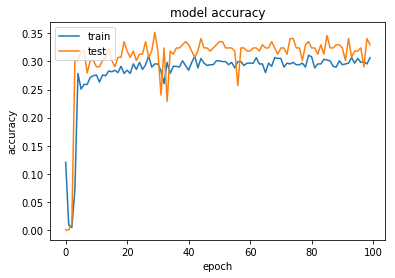

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

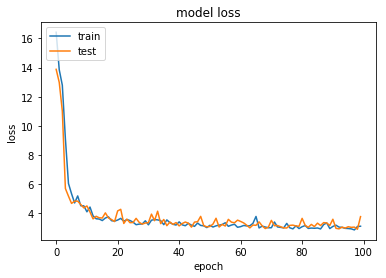

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
evaluation = NN_model.evaluate(X_test, y_test, batch_size=32)
loss = evaluation[0]
acc = evaluation[2]
print("Test loss:", loss)
print("Test accuracy:", acc)

441/441 [==============================] - 0s 41us/step
Test loss: 3.842462548322959
Test accuracy: 0.32199546694755554


# Conclusion
With the code seen above, we conclude that the Random Forest Regression model is the best model of the four, and is able to fairly accurately predict an individual's age using their methylation levels at the 6 sites. Not far behind in accuracy is the Gradient Boosting model. The Linear Regression model is not as accurately able to predict the age, but is still able to do so much much more accurately than the neural network, which was only able to achieve a testing accuracy of roughly 30%, and validation accuracy ranging from 30-35%.